In [28]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

# Scaling 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import RobustScaler

# Modeling building and hyperparameter tuning
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [29]:
def concat_df(train_data, test_data):
    ''' 
    Concatenates the training and test dataframes on axis 0
    This makes it easier to explore and manipulate the two datasets simultaneously
    '''
    return pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

def divide_df(all_data):
    ''' Divides the combined dataframe and returns the training and test dataframes '''
    return all_data.loc[:39499-1], all_data.loc[39499:].drop(['Habitability_score'], axis=1)

# reading from Kaggle (if running elsewhere - change to correct path)
df_train = pd.read_csv('../input/habitabilityhackerthon/train.csv')
df_test = pd.read_csv('../input/habitabilityhackerthon/test.csv')
df_all = concat_df(df_train, df_test)

dfs = [df_train, df_test]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Test X Shape = {df_test.shape}')

Number of Training Examples = 39499
Number of Test Examples = 10500

Training X Shape = (39499, 15)
Test X Shape = (10500, 14)


## **1. Data Exploration** 🏞️

 #### **1.1 An Overview**

In [30]:
print(df_all.info())
print(df_all.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_ID             49999 non-null  object 
 1   Property_Type           49999 non-null  object 
 2   Property_Area           49999 non-null  int64  
 3   Number_of_Windows       47900 non-null  float64
 4   Number_of_Doors         49999 non-null  int64  
 5   Furnishing              48700 non-null  object 
 6   Frequency_of_Powercuts  48250 non-null  float64
 7   Power_Backup            49999 non-null  object 
 8   Water_Supply            49999 non-null  object 
 9   Traffic_Density_Score   49999 non-null  float64
 10  Crime_Rate              49000 non-null  object 
 11  Dust_and_Noise          48450 non-null  object 
 12  Air_Quality_Index       49999 non-null  float64
 13  Neighborhood_Review     49999 non-null  float64
 14  Habitability_score      39499 non-null

- We are trying to predict the `Habitability_score` feature, which is present only in the training data.
- The `Property_ID` feature will be of no use in prediction. 
- We currently have 13 features to use for prediction - `Property_Type`, `Property_Area`, `Number_of_Windows`, `Number_of_Doors`, `Furnishing`, `Frequency_of_Powercuts`, `Power_Backup`, `Water_Supply`, `Traffic_Density_Score`, `Crime_Rate`, `Dust_and_Noise`, `Air_Quality_Index` and `Neighborhood_Review`.
- Of these 13 features, I expect `Neighborhood_Review` to be the most useful to predict `Habitability_score`.
- We have 7 continuous features - `Property_Area`, `Number_of_Windows`, `Number_of_Doors`, `Frequency_of_Powercuts`, `Traffic_Density_Score`, `Air_Quality_Index` and `Neighborhood_Review`. 
- We have 6 categorical features. Of these, 3 are nominal - `Furnishing`, `Property_Type` and `Water_Supply` - and 3 are ordinal -`Power_Backup`, `Crime_Rate` and `Dust_and_Noise`.

In [31]:
num_features = ['Property_Area',
                'Number_of_Windows', 
                'Number_of_Doors',
                'Frequency_of_Powercuts',
                'Traffic_Density_Score',
                'Air_Quality_Index',
                'Neighborhood_Review']

cat_features = ['Property_Type',
                'Water_Supply',
                'Furnishing',
                'Power_Backup',
                'Crime_Rate',
                'Dust_and_Noise']

#### **1.2 Missing Data**

In [32]:
# missing values in the training dataset 
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/len(df_train.index)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Number_of_Windows,1654,0.041874
Frequency_of_Powercuts,1383,0.035014
Dust_and_Noise,1219,0.030862
Furnishing,1042,0.026380
Crime_Rate,787,0.019925
Property_ID,0,0.000000
Property_Type,0,0.000000
Property_Area,0,0.000000
Number_of_Doors,0,0.000000
Power_Backup,0,0.000000


In [33]:
# missing data in the test dataset
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/len(df_test.index)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Number_of_Windows,445,0.042381
Frequency_of_Powercuts,366,0.034857
Dust_and_Noise,330,0.031429
Furnishing,257,0.024476
Crime_Rate,212,0.020190
Property_ID,0,0.000000
Property_Type,0,0.000000
Property_Area,0,0.000000
Number_of_Doors,0,0.000000
Power_Backup,0,0.000000


- Both training and test datasets contain missing values in the features `Number_of_Windows`, `Frequency_of_Powercuts`, `Dust_and_Noise`, `Furnishing` and `Crime_Rate`. 
- `Number_of_Windows` and `Frequency_of_Powercuts` are both numerical features, and so I will replace the missing values of these with the medium value from the training dataset.
- `Dust_and_Noise`, `Furnishing` and `Crime_Rate` are all non-numerical categorical features, and so I will replace the missing values of these with the mode value from the training dataset.

In [34]:
df_all['Number_of_Windows'] = df_all['Number_of_Windows'].fillna(df_train['Number_of_Windows'].median())
df_all['Frequency_of_Powercuts'] = df_all['Frequency_of_Powercuts'].fillna(df_train['Frequency_of_Powercuts'].median())
df_all['Crime_Rate'] = df_all['Crime_Rate'].fillna(df_train['Crime_Rate'].mode()[0])
df_all['Furnishing'] = df_all['Furnishing'].fillna(df_train['Furnishing'].mode()[0])
df_all['Dust_and_Noise'] = df_all['Dust_and_Noise'].fillna(df_train['Dust_and_Noise'].mode()[0])

df_train, df_test = divide_df(df_all)

In [35]:
# perfect! 
print(f'Missing values in training dataset: {df_train.isnull().sum().max()}')
print(f'Missing values in test dataset: {df_test.isnull().sum().max()}')

Missing values in training dataset: 0
Missing values in test dataset: 0


In [36]:
# Checking for further missing values, not given as NaN or null
for feature in cat_features:
    unique_values = df_all[feature].unique()
    print(f'The unique values in feature {feature} are: {unique_values}\n')

The unique values in feature Property_Type are: ['Apartment' 'Bungalow' 'Single-family home' 'Duplex' '#R%$G&867'
 'Container Home']

The unique values in feature Water_Supply are: ['Once in a day - Morning' 'Once in a day - Evening' 'All time'
 'NOT MENTIONED' 'Once in two days']

The unique values in feature Furnishing are: ['Semi_Furnished' 'Unfurnished' 'Fully Furnished']

The unique values in feature Power_Backup are: ['No' 'Yes' 'NOT MENTIONED']

The unique values in feature Crime_Rate are: ['Slightly below average' 'Well below average' 'Well above average'
 'Slightly above average']

The unique values in feature Dust_and_Noise are: ['Medium' 'High' 'Low']



- The feature `Property_Type` contains a strange value `#R%$G&867`.
- The features `Water_Supply` and `Power_Backup` both contain the value `NOT MENTIONED`.
- I'll replace these values with the mode from the training set.

In [37]:
df_all['Property_Type'].mask(df_all['Property_Type'] == '#R%$G&867', df_train['Property_Type'].mode()[0], inplace=True)
df_all['Water_Supply'].mask(df_all['Water_Supply'] == 'NOT MENTIONED', df_train['Water_Supply'].mode()[0], inplace=True)
df_all['Power_Backup'].mask(df_all['Power_Backup'] == 'NOT MENTIONED', df_train['Power_Backup'].mode()[0], inplace=True)

df_train, df_test = divide_df(df_all)

#### **1.3 Target Distribution**

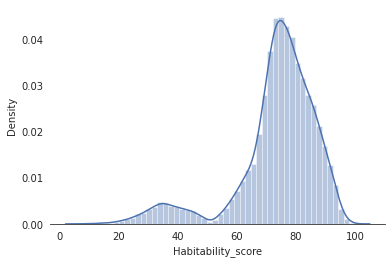

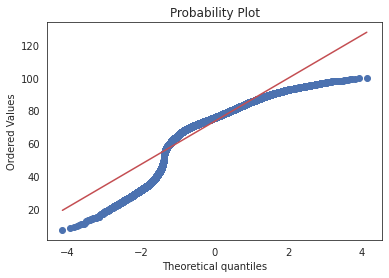

In [38]:
# histogram
sns.set_style("white")
sns.set_color_codes(palette='deep')

fig, ax = plt.subplots()

hist = sns.distplot(df_train['Habitability_score'], color="b")
sns.despine(top=True, left=True, bottom=False, trim=False)
plt.show()


res = stats.probplot(df_train['Habitability_score'], plot=plt)
plt.show()

💡 Our target variable `Habitability_score` is clearly not normally distributed. It has a negative skew and two peaks. To me, it looks like the data may come from two distinct normal distributions - one with mean around 75 and the other with mean around 35. This inspires an idea, we could:

1. Assign each training data example a label, by, say, assigning each example with `Habitability_score < 50` a label of 0 and the others a label of 1.
2. Train a classification model to predict the label of unseen data points. 
3. Train a predictive model to predict the `Habitability_score` of points with label 0, and train a second predictive model to predict the `Habitability_score` of points with label 1. 
4. Given a test example, we first predict its label using the classification model. We can then predict the `Habitability_score` for this test example using the predictive model corresponding to its assigned label.

This sounds promising, as we would be splitting our training data into two datasets - each with an approximately normally distributed target variable. My plan is not without expected drawbacks, however. Splitting the training dataset reduces the number of training examples we have to train each predictive model - this could lead to overfitting and worse generalisation. Also, the classifcation model would likely misclassify some of the test examples - introducing a source of error. 

For now, I will ignore that `Habitability_score` is not normally distributed. After all, it is technically the residuals which we assume to be normally distributed - not the target variable (though some highly-ranked Kaggle notebooks do seem to imply that having a normally distributed target variable does indeed help with predictions). After I have fit and validated one predictive model, I will try my strategy described above to see if it improves performance.


#### **1.4 Correlations**

<AxesSubplot:>

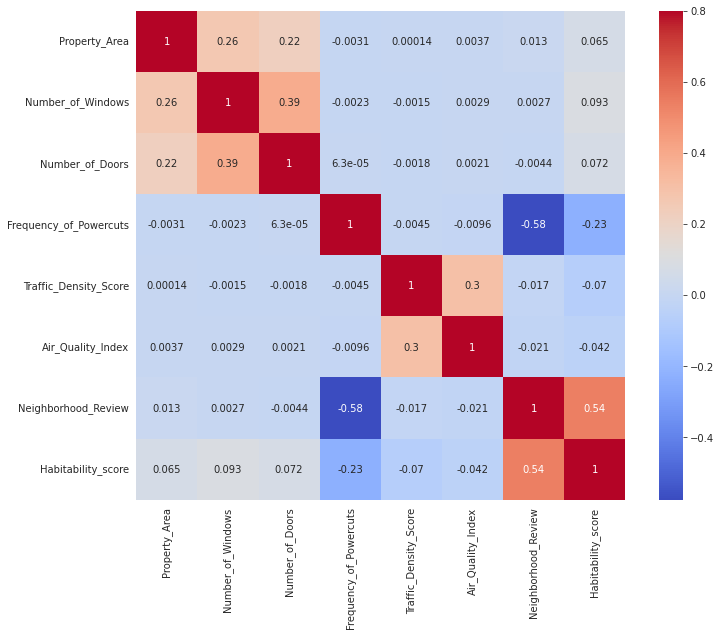

In [39]:
# correlation matrix
corrmatrix = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, vmax=0.8, cmap="coolwarm", annot=True, square=True)

- `Neighborhood_Review` is strongly correlated with `Habitability_score`.
- There is some multicolinearity between `Neighborhood_review` and `Frequency_of_Powercuts`. 

#### **1.4 Target vs Features**

<AxesSubplot:xlabel='Neighborhood_Review', ylabel='Habitability_score'>

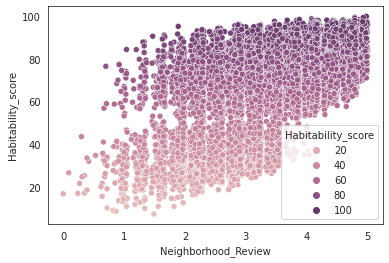

In [40]:
cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)
sns.scatterplot(x='Neighborhood_Review', y='Habitability_score', data=df_train,
               hue='Habitability_score', palette=cmap)

<AxesSubplot:xlabel='Frequency_of_Powercuts', ylabel='Habitability_score'>

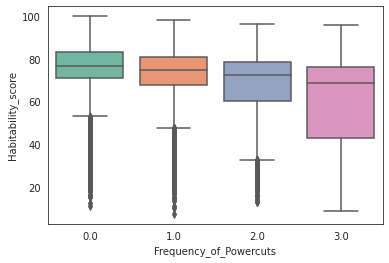

In [41]:
var = 'Frequency_of_Powercuts'
sns.boxplot(x=var, y='Habitability_score', data=df_train,
            palette='Set2')

- We can definitely see the two clusters of training examples in the `Neighborhood_review` vs `Habitability_score` scatterplot.

#### **1.6 Training vs Test Set**

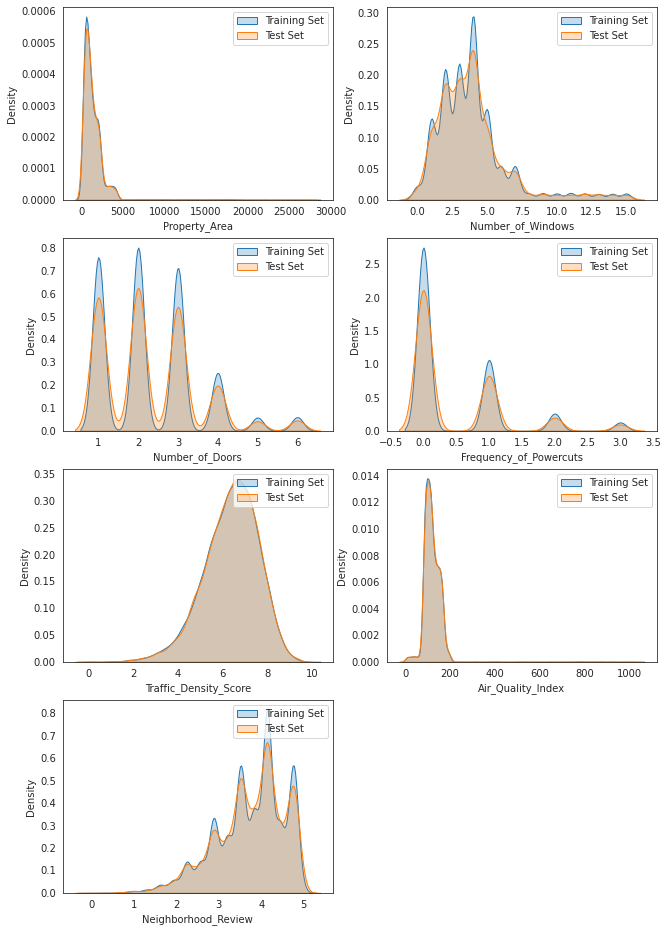

In [42]:
# Distributions of the continuous features in the training and test sets

fig, ax = plt.subplots(ncols=2, nrows=4)
plt.subplots_adjust(right=1.5, top=3.2)

for idx, feature in enumerate(num_features, 1):
    plt.subplot(4, 2, idx)
    sns.kdeplot(df_train[feature], bw='silverman', label='Training Set', shade=True)
    sns.kdeplot(df_test[feature], bw='silverman', label='Test Set', shade=True)
    
    
    plt.legend(loc='best')
    
fig.delaxes(ax[3][1])

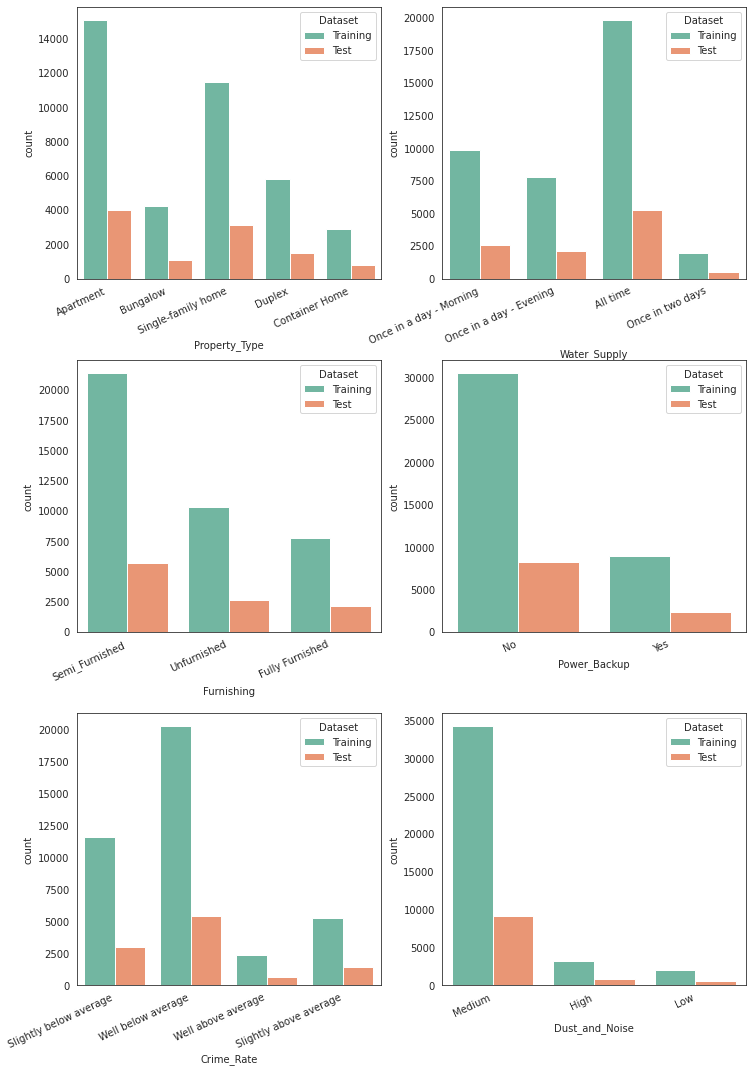

In [43]:
# Distributions of the categorical features in the training and test sets
df_train['Dataset'] = 'Training' # used for colouring 
df_test['Dataset'] = 'Test'
df_all = concat_df(df_train, df_test)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 18))
plt.subplots_adjust(hspace = .3)

for idx, feature in enumerate(cat_features, 1):
    plt.subplot(3, 2, idx)
    sns.countplot(x=feature, hue='Dataset', data=df_all, palette='Set2')
    plt.xticks(rotation=25, ha='right')
    


## **2. Feature Engineering** 🔧

#### **2.1 Feature Interactions**

In [44]:
# Captures the badness of having frequent powercuts and no backup. Not so much of an issue if you have a backup.
df_all['Frequency_of_Powercuts_AND_No_Backup'] = df_all['Frequency_of_Powercuts'] * df_all['Power_Backup'].map({'No': 1, 'Yes': 0})

#### **2.2 Feature Transformations**

In [45]:
# Introducing square of features
df_all['sq_Property_Area'] = df_all['Property_Area']**2 
df_all['sq_Number_of_Windows'] = df_all['Number_of_Windows']**2 
df_all['sq_Number_of_Doors'] = df_all['Number_of_Doors']**2 
df_all['sq_Frequency_of_Powercuts'] = df_all['Frequency_of_Powercuts']**2 
df_all['sq_Traffic_Density_Score'] = df_all['Traffic_Density_Score']**2 
df_all['sq_Air_Quality_Index'] = df_all['Air_Quality_Index']**2 
df_all['sq_Neighborhood_Review'] = df_all['Neighborhood_Review']**2
df_all['sq_Frequency_of_Powercuts_AND_No_Backup'] = df_all['Frequency_of_Powercuts_AND_No_Backup']**2

# Introducing (natural) log of features 
df_all['log_Property_Area'] = np.log(df_all['Property_Area']+1)
df_all['log_Number_of_Windows'] = np.log(df_all['Number_of_Windows']+1)
df_all['log_Number_of_Doors'] = np.log(df_all['Number_of_Doors']+1)
df_all['log_Frequency_of_Powercuts'] = np.log(df_all['Frequency_of_Powercuts']+1)
df_all['log_Traffic_Density_Score'] = np.log(df_all['Traffic_Density_Score']+1)
df_all['log_Air_Quality_Index'] = np.log(df_all['Air_Quality_Index']+1)
df_all['log_Neighborhood_Review'] = np.log(df_all['Neighborhood_Review']+1)
df_all['log_Frequency_of_Powercuts_AND_No_Backup'] = np.log(df_all['Frequency_of_Powercuts_AND_No_Backup']+1)

#### **2.3 Outliers**

<AxesSubplot:>

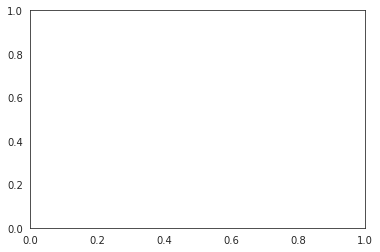

In [46]:
sns.scatterplot()

#### **2.4 Encoding**

Recall, we have 6 categorical features. Of these, 3 are nominal - `Furnishing`, `Property_Type` and `Water_Supply` - and 3 are ordinal -`Power_Backup`, `Crime_Rate` and `Dust_and_Noise`. The ordinal features will be ordinally encoded, and the nominal features will be one-hot encoded.  

##### **2.4.1 One-Hot Encoding Categorical Nominal Features**

In [47]:
nominal_features = ['Furnishing', 'Property_Type', 'Water_Supply']

encoded_features = []

for feature in nominal_features:
    encoded_df = pd.get_dummies(df_all[feature])
    encoded_df.columns = [f'{feature}_{col.replace(" ", "")}' for col in encoded_df.columns]
    encoded_features.append(encoded_df)
    
df_all = pd.concat([df_all, *encoded_features], axis=1)
df_all.drop(columns=nominal_features, inplace=True)


##### **2.4.2 Ordinal Encoding Categorical Ordinal Features**

In [48]:
powerbackup_map = {'No': 0, 'Yes': 1}
crimerate_map = {'Slightly below average': 2, 'Well below average': 1, 'Well above average': 4, 'Slightly above average': 3}
dustandnoise_map = {'Low': 1, 'Medium': 2, 'High': 3}

df_all['Power_Backup'] = df_all['Power_Backup'].map(powerbackup_map)
df_all['Crime_Rate'] = df_all['Crime_Rate'].map(crimerate_map)
df_all['Dust_and_Noise'] = df_all['Dust_and_Noise'].map(dustandnoise_map)

df_train, df_test = divide_df(df_all)

#### **2.5 Scaling**

#### **2.6 Skewness**

In [49]:
df_all.columns

Index(['Property_ID', 'Property_Area', 'Number_of_Windows', 'Number_of_Doors',
       'Frequency_of_Powercuts', 'Power_Backup', 'Traffic_Density_Score',
       'Crime_Rate', 'Dust_and_Noise', 'Air_Quality_Index',
       'Neighborhood_Review', 'Habitability_score', 'Dataset',
       'Frequency_of_Powercuts_AND_No_Backup', 'sq_Property_Area',
       'sq_Number_of_Windows', 'sq_Number_of_Doors',
       'sq_Frequency_of_Powercuts', 'sq_Traffic_Density_Score',
       'sq_Air_Quality_Index', 'sq_Neighborhood_Review',
       'sq_Frequency_of_Powercuts_AND_No_Backup', 'log_Property_Area',
       'log_Number_of_Windows', 'log_Number_of_Doors',
       'log_Frequency_of_Powercuts', 'log_Traffic_Density_Score',
       'log_Air_Quality_Index', 'log_Neighborhood_Review',
       'log_Frequency_of_Powercuts_AND_No_Backup', 'Furnishing_FullyFurnished',
       'Furnishing_Semi_Furnished', 'Furnishing_Unfurnished',
       'Property_Type_Apartment', 'Property_Type_Bungalow',
       'Property_Type_Containe

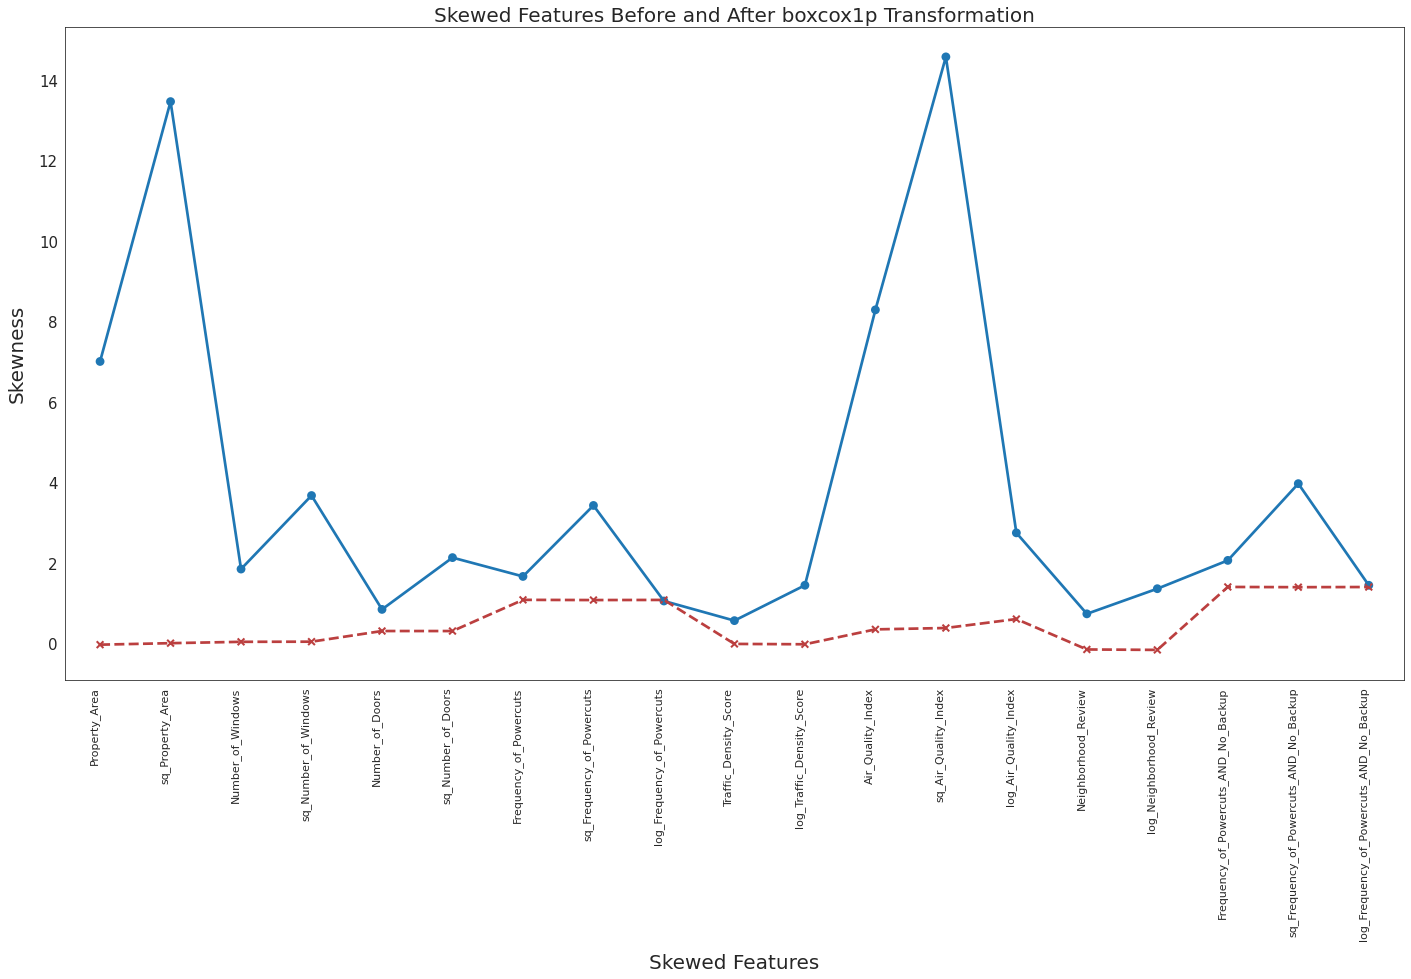

In [50]:
num_features = ['Property_Area',
                'sq_Property_Area',
                'log_Property_Area',
                'Number_of_Windows', 
                'sq_Number_of_Windows',
                'log_Number_of_Windows',
                'Number_of_Doors',
                'sq_Number_of_Doors',
                'log_Number_of_Doors',
                'Frequency_of_Powercuts',
                'sq_Frequency_of_Powercuts',
                'log_Frequency_of_Powercuts',
                'Traffic_Density_Score',
                'sq_Traffic_Density_Score',
                'log_Traffic_Density_Score',
                'Air_Quality_Index',
                'sq_Air_Quality_Index',
                'log_Air_Quality_Index',
                'Neighborhood_Review',
                'sq_Neighborhood_Review',
                'log_Neighborhood_Review',
                'Frequency_of_Powercuts_AND_No_Backup',
                'sq_Frequency_of_Powercuts_AND_No_Backup',
                'log_Frequency_of_Powercuts_AND_No_Backup']

skewed_features = {feature: abs(df_all[feature].skew()) for feature in num_features if abs(df_all[feature].skew()) >= 0.5}
transformed_skews = {}

for feature in skewed_features.keys():
    df_all[feature] = boxcox1p(df_all[feature], boxcox_normmax(df_all[feature] + 1))
    transformed_skews[feature] = df_all[feature].skew()
    
df_skew = pd.DataFrame(index=skewed_features.keys(), columns=['Skew', 'Skew after boxcox1p'])
df_skew['Skew'] = skewed_features.values()
df_skew['Skew after boxcox1p'] = transformed_skews.values()

fig = plt.figure(figsize=(24, 12))

sns.pointplot(x=df_skew.index, y='Skew', data=df_skew, markers=['o'], linestyles=['-'])
sns.pointplot(x=df_skew.index, y='Skew after boxcox1p', data=df_skew, markers=['x'], linestyles=['--'], color='#bb3f3f')

plt.xlabel('Skewed Features', size=20, labelpad=12.5)
plt.ylabel('Skewness', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=15)

plt.title('Skewed Features Before and After boxcox1p Transformation', size=20)
plt.xticks(rotation=90, ha='right')

plt.show()

#### **2.7 Conclusion**

In [51]:
df_train, df_test = divide_df(df_all)
print(f'Training X Shape = {df_train.shape}')
print(f'Test X Shape = {df_test.shape}\n')

# correlations between Habitability_score and features
print(abs(df_train[df_train.columns[1:]].corr()['Habitability_score'][:]).sort_values(ascending=False))

Training X Shape = (39499, 42)
Test X Shape = (10500, 41)

Habitability_score                          1.000000
sq_Neighborhood_Review                      0.512877
log_Neighborhood_Review                     0.508871
Neighborhood_Review                         0.508643
Crime_Rate                                  0.436452
Furnishing_Unfurnished                      0.406075
Frequency_of_Powercuts_AND_No_Backup        0.289273
log_Frequency_of_Powercuts_AND_No_Backup    0.289234
sq_Frequency_of_Powercuts_AND_No_Backup     0.288642
Furnishing_FullyFurnished                   0.265485
Power_Backup                                0.264474
Frequency_of_Powercuts                      0.219913
log_Frequency_of_Powercuts                  0.219865
sq_Frequency_of_Powercuts                   0.219258
Water_Supply_Alltime                        0.162314
Furnishing_Semi_Furnished                   0.146656
Water_Supply_Onceintwodays                  0.139272
Property_Area                           

In [52]:
# Removing the skewness of sq_Property_Area has caused a problem - I'll remove this feature
df_all.drop(columns=['sq_Property_Area'], inplace=True)
df_train, df_test = divide_df(df_all)
print(f'Training X Shape = {df_train.shape}')
print(f'Test X Shape = {df_test.shape}')

Training X Shape = (39499, 41)
Test X Shape = (10500, 40)


In [53]:
df_train.to_csv("habitability_train_0811.csv", index=False)
df_test.to_csv("habitability_test_0811.csv", index=False)

## **3. Model Building**  🏄‍

#### **3.1 Readying the Data**

In [54]:
print(f'Training dataset shape = {df_train.shape}')
print(f'Test dataset shape = {df_test.shape}')

Training dataset shape = (39499, 41)
Test dataset shape = (10500, 40)


In [55]:
# Removing the columns unhelpful for prediction 
df_all.drop(columns=['Property_ID', 'Dataset'], inplace=True)

df_train, X_df_test = divide_df(df_all)

# Seperating target from predictors
y_df_train = df_train['Habitability_score']
X_df_train = df_train.drop(columns=['Habitability_score'])


print(f'X_train shape: {X_df_train.shape}')
print(f'y_train shape: {y_df_train.shape}')
print(f'X_test shape: {X_df_test.shape}')

X_train shape: (39499, 38)
y_train shape: (39499,)
X_test shape: (10500, 38)


#### **3.2 Building the Models**

In [58]:
SEED=42

# tree based models
xgb_model = XGBRegressor(n_estimators = 850,
                        learning_rate = 0.01,
                        max_depth = 14,
                        subsample = 0.9,
                        eta = 0.03,
                        gamma = 1.0,
                        reg_alpha = 6,
                        reg_lambda = 80,
                        # tree_method = 'gpu_hist',
                        seed=SEED)

lgbm_model = LGBMRegressor(n_estimators = 4800,
                          learning_rate = 0.01,
                          num_leaves = 81,
                          max_depth = 11,
                          max_bin = 270,
                          bagging_fraction = 0.9,
                          bagging_freq = 6,
                          bagging_seed = SEED,
                          feature_fraction = 0.9,
                          feature_fraction_seed = SEED,
                          objective='regression')

gbr_model = GradientBoostingRegressor(n_estimators = 3100,
                                      learning_rate = 0.060000000000000005,
                                      max_depth = 8,
                                      subsample = 0.8,
                                      max_features = 'auto',
                                      min_samples_leaf = 6, 
                                      min_samples_split = 13,
                                      random_state = SEED)

rf_model = RandomForestRegressor(n_estimators = 200,
                                 max_depth = 16,
                                 min_samples_split = 2,
                                 min_samples_leaf = 8,
                                 max_features = None,
                                 oob_score = True)
                

# support vector machine model
svr_model = make_pipeline(RobustScaler(), SVR(C=30, epsilon=0.001, gamma=0.09999999999999999))

# linear models with regularisation 
ridge_model = make_pipeline(RobustScaler(), RidgeCV(alphas = np.arange(0.0005, 0.0015, 0.0001)))
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha = 0.0))
elasticnet_model = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0, l1_ratio = 0.0))

# meta stacked super model
stack_super_model = StackingCVRegressor(regressors=(xgb_model, lgbm_model, rf_model, svr_model, ridge_model, lasso_model, elasticnet_model),
                                        meta_regressor = xgb_model,
                                        random_state = SEED, 
                                        use_features_in_secondary=True)

In [59]:
models = {'XGBoostRegressor': xgb_model,
          'LightGBMRegressor': lgbm_model,
          #'GradientBoostingRegressor': gbr_model,
          'RandomForestRegressor': rf_model,
          'SupportVectorRegressor': svr_model,
          'RidgeCV': ridge_model,
          'Lasso': lasso_model,
          'ElasticNet': elasticnet_model,
          'StackingCVRegressor': stack_super_model}

# Fitting each model
for model_name, model in models.items():
    start_time = datetime.now()
    print(f'[{start_time}] Training {model_name}')
    
    model.fit(X_df_train, y_df_train)
    
    end_time = datetime.now()
    print(f'[{end_time}] Finished Training {model_name}\n')

[2022-08-14 17:30:56.569357] Training XGBoostRegressor
[2022-08-14 17:32:11.185693] Finished Training XGBoostRegressor

[2022-08-14 17:32:11.185810] Training LightGBMRegressor
[2022-08-14 17:32:39.325099] Finished Training LightGBMRegressor

[2022-08-14 17:32:39.325200] Training RandomForestRegressor
[2022-08-14 17:33:46.700357] Finished Training RandomForestRegressor

[2022-08-14 17:33:46.700473] Training SupportVectorRegressor
[2022-08-14 17:45:02.702732] Finished Training SupportVectorRegressor

[2022-08-14 17:45:02.702861] Training RidgeCV
[2022-08-14 17:45:02.871516] Finished Training RidgeCV

[2022-08-14 17:45:02.871597] Training Lasso
[2022-08-14 17:45:03.691457] Finished Training Lasso

[2022-08-14 17:45:03.691825] Training ElasticNet
[2022-08-14 17:45:04.854319] Finished Training ElasticNet

[2022-08-14 17:45:04.854446] Training StackingCVRegressor
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[Light

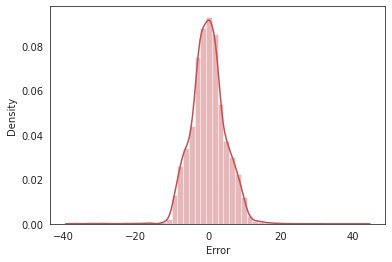

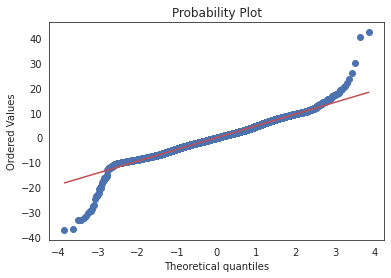

Score: 86.30988


In [60]:
# validation of StackingCVREgressor model with error plot to check for normality in the errors
# k-fold cross validation will take too long, as the GradientBoostingRegressor (and SVR to a lesser extent) is very slow

X_train, X_valid, y_train, y_valid = train_test_split(X_df_train, y_df_train, test_size=0.3, random_state=42)
    
valid_pred = stack_super_model.predict(X_valid)
    
score = max(0, 100*(r2_score(valid_pred, y_valid)))
    
# plotting errors 
errors = y_valid - valid_pred
sns.distplot(errors, color="r")
plt.xlabel('Error')
plt.show()

# checking normality
res = stats.probplot(errors, plot=plt)
plt.show()
    
print(f'Score: {score:.5f}')

In [ ]:
cv_scores = {'xgb': 0.8222257674663099,
             'lgbm': 0.8174503546552729,
             'gbr': 0.8018167,
             'rf': 0.8210146178488404
             'svr': 0.7822675938428986, 
             'ridge': 0.6157446362981414,
             'lasso': 0.588415569291112,
             'elasticnet': 0.588415569291112,
             'stack': 0.8630988       # only 2 fold validation - but wow! 
            }

In [61]:
# saving predictions from stacked model
stack_preds = stack_super_model.predict(X_df_test)
stack_submission = pd.DataFrame({"Property_ID": df_test['Property_ID'], "Habitability_score": stack_preds})
print(stack_submission.head())
stack_submission.to_csv("stack_submission_wrf.csv")

      Property_ID  Habitability_score
39499      0x6e93           30.250702
39500      0x8787           81.438744
39501      0x6c17           66.780952
39502      0x9dbd           70.836449
39503      0xbfde           76.815872


#### **3.3 Blending**

In [63]:
def blend_model_predictions(X):
    return ((0.0 * elasticnet_model.predict(X)) + 
            (0.0 * lasso_model.predict(X)) +
            (0.0 * ridge_model.predict(X)) +
            (0.1 * svr_model.predict(X)) +
            (0.1 * rf_model.predict(X)) +
            (0.1 * xgb_model.predict(X)) +
            (0.1 * lgbm_model.predict(X)) +
            (0.6 * stack_super_model.predict(X)))

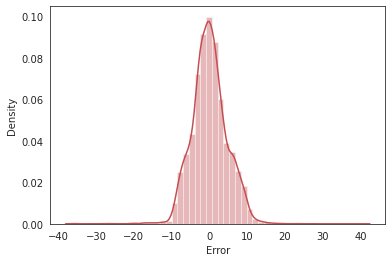

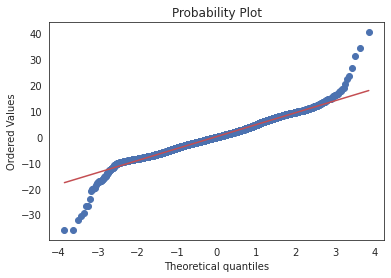

Score: 87.13284


In [64]:
# validation of blended model with error plot to check for normality in the errors

X_train, X_valid, y_train, y_valid = train_test_split(X_df_train, y_df_train, test_size=0.3, random_state=30)
    
valid_pred = blend_model_predictions(X_valid)
    
score = max(0, 100*(r2_score(valid_pred, y_valid)))
    
# plotting errors 
errors = y_valid - valid_pred
sns.distplot(errors, color="r")
plt.xlabel('Error')
plt.show()

# checking normality
res = stats.probplot(errors, plot=plt)
plt.show()
    
print(f'Score: {score:.5f}')

In [65]:
# this isn't proper k-fold validation, as the blended model has been fit to the whole dataset.
K = 5
kf_score = []

for fold, (train_idx, valid_idx) in enumerate(KFold(n_splits=K, shuffle=True, random_state=0).split(X_df_train,y_df_train)):
    X_train, y_train = X_df_train.iloc[train_idx], y_df_train[train_idx]
    X_valid, y_valid = X_df_train.iloc[valid_idx], y_df_train[valid_idx]
    
    valid_pred = model.predict(X_valid)
    score = max(0, 100*(r2_score(valid_pred, y_valid)))
    
    print(f'Fold {fold+1}/{K} Score: {score:.4f}')
    kf_score.append(score)

print(f'Average KFold Score: {np.mean(np.array(kf_score)):.5f}')

Fold 1/5 Score: 86.4709
Fold 2/5 Score: 86.2850
Fold 3/5 Score: 86.7178
Fold 4/5 Score: 87.3433
Fold 5/5 Score: 86.9159
Average KFold Score: 86.74659


In [66]:
# saving predictions from blended model
blend_preds = blend_model_predictions(X_df_test)
blend_submission = pd.DataFrame({"Property_ID": df_test['Property_ID'], "Habitability_score": blend_preds})
print(blend_submission.head())
blend_submission.to_csv("blend_submission3.csv")

      Property_ID  Habitability_score
39499      0x6e93           29.497469
39500      0x8787           80.886848
39501      0x6c17           66.474390
39502      0x9dbd           71.209399
39503      0xbfde           76.801208
